<br>
<br>
**<font size=8><center>Milestone 4</center></font>**

**<font size=6>Introduction</font>**

Below are four baseline models for the Lending Club analysis. These are simple models that treat the problem as binary classification. The outcomes can either be "default" or "not default". These models take simplicitic views of the problem and serve as baselines for comparison and sanity check when more sofisiticated models are built in later parts of the project.

The models are:
1. predict all outcomes to be "not default";
2. predict all outcomes of borrowers with lowest credit scores to always :default" and others "not default";
3. model outcomes with a single predictor "grade";
4. model outcomes with a single predictor "interest rate".

The data cleaning steps are from milestone 3.

### Authors:
Devon Luongo <br>
Ankit Agarwal <br>
Bryn Clark <br>
Ben Yuen

### Libraries:

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
import matplotlib.cm as cmx
import matplotlib.colors as colors
import scipy
%matplotlib inline


#new imports for milestone 4
import StringIO
from IPython.display import Image
#import pydotplus
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import accuracy_score, f1_score, make_scorer, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.metrics  import confusion_matrix
import itertools
from sklearn.cross_validation import train_test_split

/home/ankit/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
path = "/home/ankit/anaconda2/pkgs/basemap-1.0.7-np111py27_0/lib/python2.7/site-packages/mpl_toolkits/basemap/data/"

**<font size=6>Data Cleaning</font>**

Some of the data files have fields that contain NAs for older time periods. In order to collapse the data sets into one file, all numerical data will be stored in float fields (integer fields do not support NA missing values). To do this, we first define a conversion dictionary that stores the numeric fields with lookups to the *float* data type.

In [3]:
convert_float = dict([s, float] for s in
                     ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'installment',
                      'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq',                      
                      'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'total_acc',
                      'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
                      'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
                      'last_pymnt_amnt', 'collections_12_mths_ex_med', 'mths_since_last_major_derog',
                      'annual_inc_joint', 'dti_joint', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 
                      'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 
                      'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 
                      'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 
                      'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
                      'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct',
                      'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc',
                      'mths_since_recent_bc', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq',
                      'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 
                      'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl',
                      'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m',
                      'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq',
                      'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tax_liens', 'tot_hi_cred_lim',
                      'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit'])

We also define a dictionary of string fields, to handle situations where the inferred data type might be numeric even though the field should be read in as a string/object.

In [4]:
convert_str = dict([s, str] for s in
                    ['term', 'int_rate', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 
                     'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 
                     'purpose', 'title', 'zip_code', 'addr_state', 'earliest_cr_line', 'revol_util', 
                     'initial_list_status', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d',
                     'policy_code', 'application_type', 'verification_status_joint'])

We read the input data from the CSV data files using pandas *read_csv*. There is a blank row in the data header and there are two blank rows in the footer of each file. To allow the use of *skip_footer*, we use the python engine rather than the C engine. The first two columns (*id* and *member_id*) are unique and used to create a table index.

In [5]:
data_2007_2011 = pd.read_csv("./data/LoanStats3a.csv",
                   skiprows=1,
                   skip_footer=2,
                   engine="python",
                   na_values=['NaN', 'nan'],
                   converters=convert_str,
                   index_col=[0,1])

data_2014 = pd.read_csv("./data/LoanStats3b.csv",
                   skiprows=1,
                   skip_footer=2,
                   engine="python",
                   na_values=['NaN', 'nan'],
                   converters=convert_str,
                   index_col=[0,1])

data_2015 = pd.read_csv("./data/LoanStats3c.csv",
                   skiprows=1,
                   skip_footer=2,
                   engine="python",
                   na_values=['NaN', 'nan'],
                   converters=convert_str,
                   index_col=[0,1])

data = pd.read_csv("./data/LoanStats3d.csv",
                   skiprows=1,
                   skip_footer=2,
                   engine="python",
                   na_values=['NaN', 'nan'],
                   converters=convert_str,
                   index_col=[0,1])

/home/ankit/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: The 'skip_footer' argument has been deprecated and will be removed in a future version. Please use the 'skipfooter' argument instead.
/home/ankit/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:15: FutureWarning: The 'skip_footer' argument has been deprecated and will be removed in a future version. Please use the 'skipfooter' argument instead.
/home/ankit/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: FutureWarning: The 'skip_footer' argument has been deprecated and will be removed in a future version. Please use the 'skipfooter' argument instead.
/home/ankit/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:31: FutureWarning: The 'skip_footer' argument has been deprecated and will be removed in a future version. Please use the 'skipfooter' argument instead.


In [6]:
print "Data table dimensions 2007-2011: %d x %d" % data_2007_2011.shape

print "Data table dimensions 2014: %d x %d" % data_2014.shape
 
print "Data table dimensions 2015: %d x %d" % data_2015.shape

print "Data table dimensions 2016: %d x %d" % data.shape

Data table dimensions 2007-2011: 42536 x 109
Data table dimensions 2014: 188181 x 109
Data table dimensions 2015: 235629 x 109
Data table dimensions 2016: 421095 x 109


In [7]:
data.head()

,,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
id,member_id,,,,,,,,,,,,,,,,,,,,,
68516507,73406314,14000,14000,14000,36 months,9.80%,450.43,B,B3,Master mechanic,4 years,...,0,2,100.0,0.0,0,0,531602,84039,34500,55842
68587652,73477494,25000,25000,25000,36 months,5.32%,752.87,A,A1,Director,1 year,...,0,1,100.0,0.0,0,0,512381,44786,44000,51081
68009401,72868139,16000,16000,16000,60 months,14.85%,379.39,C,C5,Bookkeeper/Accounting,10+ years,...,0,2,78.9,0.0,0,2,298100,31329,281300,13400
68416935,73306760,15000,15000,15000,36 months,9.80%,482.61,B,B3,Electronic Branch Manager,3 years,...,0,4,100.0,0.0,1,0,347470,53397,36100,47370
68357012,73246847,15000,15000,15000,36 months,8.49%,473.45,B,B1,Senior Associate,6 years,...,0,4,100.0,20.0,1,0,369112,27849,28200,21124


In [8]:
data_2015.head()

,,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
id,member_id,,,,,,,,,,,,,,,,,,,,,
38098114,40860827,15000,15000,15000,60 months,12.39%,336.64,C,C1,MANAGEMENT,10+ years,...,0,4,100.0,0.0,0,0,196500,149140,10000,12000
36805548,39558264,10400,10400,10400,36 months,6.99%,321.08,A,A3,Truck Driver Delivery Personel,8 years,...,0,4,83.3,14.3,0,0,179407,15030,13000,11325
37822187,40585251,9600,9600,9600,36 months,13.66%,326.53,C,C3,Admin Specialist,10+ years,...,0,3,100.0,60.0,0,0,52490,38566,21100,24890
37612354,40375473,12800,12800,12800,60 months,17.14%,319.08,D,D4,Senior Sales Professional,10+ years,...,0,0,76.9,100.0,0,0,368700,18007,4400,18000
37662224,40425321,7650,7650,7650,36 months,13.66%,260.20,C,C3,Technical Specialist,< 1 year,...,0,2,100.0,100.0,0,0,82331,64426,4900,64031


Check the count of fields by data type:

In [9]:
data_2014.head()

,,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
id,member_id,,,,,,,,,,,,,,,,,,,,,
10159611,12011228,10000,10000,10000.0,36 months,9.67%,321.13,B,B1,Registered Nurse,7 years,...,0.0,1.0,77.3,66.7,0,0,58486.0,39143.0,9200.0,36186.0
10129477,11981093,14000,14000,14000.0,36 months,12.85%,470.71,B,B4,Assistant Director - Human Resources,4 years,...,0.0,0.0,78.6,100.0,1,0,31840.0,17672.0,3900.0,27340.0
10149342,12000897,27050,27050,27050.0,36 months,10.99%,885.46,B,B2,Team Leadern Customer Ops & Systems,10+ years,...,0.0,1.0,100.0,25.0,0,0,138554.0,70186.0,35700.0,33054.0
10139658,11991209,12000,12000,12000.0,36 months,13.53%,407.40,B,B5,On road manager,10+ years,...,0.0,2.0,81.2,33.3,0,0,18130.0,13605.0,7000.0,10030.0
10159548,12011167,15000,15000,15000.0,36 months,8.90%,476.30,A,A5,aircraft maintenance engineer,2 years,...,0.0,0.0,89.3,66.7,0,0,288195.0,39448.0,14200.0,33895.0


In [10]:
data_2007_2011.head()

,,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
id,member_id,,,,,,,,,,,,,,,,,,,,,
1077501,1296599.0,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,NaN,10+ years,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1077430,1314167.0,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1077175,1313524.0,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,NaN,10+ years,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1076863,1277178.0,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,C1,AIR RESOURCES BOARD,10+ years,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1075358,1311748.0,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,B5,University Medical Group,1 year,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


In [11]:
print data_2007_2011.dtypes.value_counts()
print
print data_2014.dtypes.value_counts()
print
print data_2015.dtypes.value_counts()
print
data.dtypes.value_counts()

float64    83
object     26
dtype: int64

float64    69
object     26
int64      14
dtype: int64

float64    43
int64      40
object     26
dtype: int64



float64    43
int64      40
object     26
dtype: int64

Depending on the specific dataset used, the numeric values may be read in as integers. For best performance and to enable mergining of the datasets, we convert those fields to floats (which allow NaN values):

In [12]:
for k, v in convert_float.items():
    data_2007_2011[k] = data_2007_2011[k].astype(v)
    data_2014[k] = data_2014[k].astype(v)
    data_2015[k] = data_2015[k].astype(v)
    data[k] = data[k].astype(v)

Checking the data types after the float conversion:

In [13]:
print data_2007_2011.dtypes.value_counts()
print
print data_2014.dtypes.value_counts()
print
print data_2015.dtypes.value_counts()
print
data.dtypes.value_counts()

float64    83
object     26
dtype: int64

float64    83
object     26
dtype: int64

float64    83
object     26
dtype: int64



float64    83
object     26
dtype: int64

The object fields need some more processing. First, we list out those fields:

In [14]:
data.dtypes[data.dtypes=="object"]
data_2007_2011.dtypes[data_2007_2011.dtypes=="object"]
data_2014.dtypes[data_2014.dtypes=="object"]
data_2015.dtypes[data_2015.dtypes=="object"]

term                         object
int_rate                     object
grade                        object
sub_grade                    object
emp_title                    object
emp_length                   object
home_ownership               object
verification_status          object
issue_d                      object
loan_status                  object
pymnt_plan                   object
url                          object
desc                         object
purpose                      object
title                        object
zip_code                     object
addr_state                   object
earliest_cr_line             object
revol_util                   object
initial_list_status          object
last_pymnt_d                 object
next_pymnt_d                 object
last_credit_pull_d           object
policy_code                  object
application_type             object
verification_status_joint    object
dtype: object

There are 5 object fields that contain dates in the format *YYYY-MMM* (e.g. '2010-Jan'). We parse those to return datetime fields, which are more easily input into time series models or plotted in charts.

In [15]:
data.issue_d = pd.to_datetime(data.issue_d, errors="coerce")
data.last_pymnt_d = pd.to_datetime(data.last_pymnt_d, errors="coerce")
data.next_pymnt_d = pd.to_datetime(data.next_pymnt_d, errors="coerce")
data.last_credit_pull_d = pd.to_datetime(data.last_credit_pull_d, errors="coerce")
data.earliest_cr_line = pd.to_datetime(data.earliest_cr_line, errors="coerce")

data_2007_2011.issue_d = pd.to_datetime(data_2007_2011.issue_d, errors="coerce")
data_2007_2011.last_pymnt_d = pd.to_datetime(data_2007_2011.last_pymnt_d, errors="coerce")
data_2007_2011.next_pymnt_d = pd.to_datetime(data_2007_2011.next_pymnt_d, errors="coerce")
data_2007_2011.last_credit_pull_d = pd.to_datetime(data_2007_2011.last_credit_pull_d, errors="coerce")
data_2007_2011.earliest_cr_line = pd.to_datetime(data_2007_2011.earliest_cr_line, errors="coerce")

data_2014.issue_d = pd.to_datetime(data_2014.issue_d, errors="coerce")
data_2014.last_pymnt_d = pd.to_datetime(data_2014.last_pymnt_d, errors="coerce")
data_2014.next_pymnt_d = pd.to_datetime(data_2014.next_pymnt_d, errors="coerce")
data_2014.last_credit_pull_d = pd.to_datetime(data_2014.last_credit_pull_d, errors="coerce")
data_2014.earliest_cr_line = pd.to_datetime(data_2014.earliest_cr_line, errors="coerce")

data_2015.issue_d = pd.to_datetime(data_2015.issue_d, errors="coerce")
data_2015.last_pymnt_d = pd.to_datetime(data_2015.last_pymnt_d, errors="coerce")
data_2015.next_pymnt_d = pd.to_datetime(data_2015.next_pymnt_d, errors="coerce")
data_2015.last_credit_pull_d = pd.to_datetime(data_2015.last_credit_pull_d, errors="coerce")
data_2015.earliest_cr_line = pd.to_datetime(data_2015.earliest_cr_line, errors="coerce")

Many of the remaining fields contain categorical data. We use the pandas *category* data type to store the data more efficiently.

In [16]:
data.term = pd.Categorical(data.term, categories= [" 36 months", " 60 months", "None"])
data.grade = pd.Categorical(data.grade, categories=["A", "B", "C", "D", "E", "F", "G", "None"])
data.sub_grade = pd.Categorical(data.sub_grade, categories=["A1", "A2", "A3", "A4", "A5",
                                                            "B1", "B2", "B3", "B4", "B5", 
                                                            "C1", "C2", "C3", "C4", "C5",
                                                            "D1", "D2", "D3", "D4", "D5",
                                                            "E1", "E2", "E3", "E4", "E5",
                                                            "F1", "F2", "F3", "F4", "F5",
                                                            "G1", "G2", "G3", "G4", "G5",
                                                            "None"])
data.home_ownership = pd.Categorical(data.home_ownership.str.title(), categories=["Own", "Mortgage", "Rent", "Any", "Other", "None"])
data.emp_length = pd.Categorical(data.emp_length, categories=["< 1 year", "1 year", "2 years", "3 years",
                                                              "4 years", "5 years", "6 years", "7 years",
                                                              "8 years", "9 years", "10+ years", "n/a", "None"])
data.verification_status = pd.Categorical(data.verification_status, categories=["Verified", "Source Verified", "Not Verified", "None"])
data.loan_status = pd.Categorical(data.loan_status, categories=["Fully Paid", "Current", "Charged Off",
                                                                "Does not meet the credit policy. Status:Fully Paid",
                                                                "Does not meet the credit policy. Status:Charged Off",
                                                                "In Grace Period", "Late (16-30 days)", "Late (31-120 days)",
                                                                "Default", "None"])
data.pymnt_plan = pd.Categorical(data.pymnt_plan.str.title(), categories=["Y", "N", "None"])
data.purpose = pd.Categorical(data.purpose.str.title(),
                              categories=["Debt_Consolidation", "Credit_Card", "Home_Improvement", "Major_Purchase", 
                                          "Small_Business", "Car", "Wedding", "Medical", "Moving", "House",
                                          "Educational", "Vacation", "Renewable_Energy", "Other", "None"])
data.addr_state = pd.Categorical(data.addr_state,
                                 categories=["AK", "AL", "AR", "AZ", "CA", "CO", "CT", "DC", "DE", "FL",
                                             "GA", "HI", "IA", "ID", "IL", "IN", "KS", "KY", "LA", "MA",
                                             "MD", "ME", "MI", "MN", "MO", "MS", "MT", "NC", "ND", "NE",
                                             "NH", "NJ", "NM", "NV", "NY", "OH", "OK", "OR", "PA", "RI",
                                             "SC", "SD", "TN", "TX", "UT", "VA", "VT", "WA", "WI", "WV",
                                             "WY", "None"])
data.initial_list_status = pd.Categorical(data.initial_list_status, categories=["f", "w", "None"])
data.policy_code = pd.Categorical(data.policy_code, categories=["1", "None"])
data.application_type = pd.Categorical(data.application_type.str.title(), categories=["Individual", "Joint", "None"])
data.verification_status_joint = pd.Categorical(data.verification_status_joint, categories=["Verified", "Source Verified", "Not Verified", "None"])

In [17]:
data_2007_2011.term = pd.Categorical(data_2007_2011.term, categories= [" 36 months", " 60 months", "None"])
data_2007_2011.grade = pd.Categorical(data_2007_2011.grade, categories=["A", "B", "C", "D", "E", "F", "G", "None"])
data_2007_2011.sub_grade = pd.Categorical(data_2007_2011.sub_grade, categories=["A1", "A2", "A3", "A4", "A5",
                                                            "B1", "B2", "B3", "B4", "B5", 
                                                            "C1", "C2", "C3", "C4", "C5",
                                                            "D1", "D2", "D3", "D4", "D5",
                                                            "E1", "E2", "E3", "E4", "E5",
                                                            "F1", "F2", "F3", "F4", "F5",
                                                            "G1", "G2", "G3", "G4", "G5",
                                                            "None"])
data_2007_2011.home_ownership = pd.Categorical(data_2007_2011.home_ownership.str.title(), categories=["Own", "Mortgage", "Rent", "Any", "Other", "None"])
data_2007_2011.emp_length = pd.Categorical(data_2007_2011.emp_length, categories=["< 1 year", "1 year", "2 years", "3 years",
                                                              "4 years", "5 years", "6 years", "7 years",
                                                              "8 years", "9 years", "10+ years", "n/a", "None"])
data_2007_2011.verification_status = pd.Categorical(data_2007_2011.verification_status, categories=["Verified", "Source Verified", "Not Verified", "None"])
data_2007_2011.loan_status = pd.Categorical(data_2007_2011.loan_status, categories=["Fully Paid", "Current", "Charged Off",
                                                                "Does not meet the credit policy. Status:Fully Paid",
                                                                "Does not meet the credit policy. Status:Charged Off",
                                                                "In Grace Period", "Late (16-30 days)", "Late (31-120 days)",
                                                                "Default", "None"])
data_2007_2011.pymnt_plan = pd.Categorical(data_2007_2011.pymnt_plan.str.title(), categories=["Y", "N", "None"])
data_2007_2011.purpose = pd.Categorical(data_2007_2011.purpose.str.title(),
                              categories=["Debt_Consolidation", "Credit_Card", "Home_Improvement", "Major_Purchase", 
                                          "Small_Business", "Car", "Wedding", "Medical", "Moving", "House",
                                          "Educational", "Vacation", "Renewable_Energy", "Other", "None"])
data_2007_2011.addr_state = pd.Categorical(data_2007_2011.addr_state,
                                 categories=["AK", "AL", "AR", "AZ", "CA", "CO", "CT", "DC", "DE", "FL",
                                             "GA", "HI", "IA", "ID", "IL", "IN", "KS", "KY", "LA", "MA",
                                             "MD", "ME", "MI", "MN", "MO", "MS", "MT", "NC", "ND", "NE",
                                             "NH", "NJ", "NM", "NV", "NY", "OH", "OK", "OR", "PA", "RI",
                                             "SC", "SD", "TN", "TX", "UT", "VA", "VT", "WA", "WI", "WV",
                                             "WY", "None"])
data_2007_2011.initial_list_status = pd.Categorical(data_2007_2011.initial_list_status, categories=["f", "w", "None"])
data_2007_2011.policy_code = pd.Categorical(data_2007_2011.policy_code, categories=["1", "None"])
data_2007_2011.application_type = pd.Categorical(data_2007_2011.application_type.str.title(), categories=["Individual", "Joint", "None"])
data_2007_2011.verification_status_joint = pd.Categorical(data_2007_2011.verification_status_joint, categories=["Verified", "Source Verified", "Not Verified", "None"])

In [18]:
data_2014.term = pd.Categorical(data_2014.term, categories= [" 36 months", " 60 months", "None"])
data_2014.grade = pd.Categorical(data_2014.grade, categories=["A", "B", "C", "D", "E", "F", "G", "None"])
data_2014.sub_grade = pd.Categorical(data_2014.sub_grade, categories=["A1", "A2", "A3", "A4", "A5",
                                                            "B1", "B2", "B3", "B4", "B5", 
                                                            "C1", "C2", "C3", "C4", "C5",
                                                            "D1", "D2", "D3", "D4", "D5",
                                                            "E1", "E2", "E3", "E4", "E5",
                                                            "F1", "F2", "F3", "F4", "F5",
                                                            "G1", "G2", "G3", "G4", "G5",
                                                            "None"])
data_2014.home_ownership = pd.Categorical(data_2014.home_ownership.str.title(), categories=["Own", "Mortgage", "Rent", "Any", "Other", "None"])
data_2014.emp_length = pd.Categorical(data_2014.emp_length, categories=["< 1 year", "1 year", "2 years", "3 years",
                                                              "4 years", "5 years", "6 years", "7 years",
                                                              "8 years", "9 years", "10+ years", "n/a", "None"])
data_2014.verification_status = pd.Categorical(data_2014.verification_status, categories=["Verified", "Source Verified", "Not Verified", "None"])
data_2014.loan_status = pd.Categorical(data_2014.loan_status, categories=["Fully Paid", "Current", "Charged Off",
                                                                "Does not meet the credit policy. Status:Fully Paid",
                                                                "Does not meet the credit policy. Status:Charged Off",
                                                                "In Grace Period", "Late (16-30 days)", "Late (31-120 days)",
                                                                "Default", "None"])
data_2014.pymnt_plan = pd.Categorical(data_2014.pymnt_plan.str.title(), categories=["Y", "N", "None"])
data_2014.purpose = pd.Categorical(data_2014.purpose.str.title(),
                              categories=["Debt_Consolidation", "Credit_Card", "Home_Improvement", "Major_Purchase", 
                                          "Small_Business", "Car", "Wedding", "Medical", "Moving", "House",
                                          "Educational", "Vacation", "Renewable_Energy", "Other", "None"])
data_2014.addr_state = pd.Categorical(data_2014.addr_state,
                                 categories=["AK", "AL", "AR", "AZ", "CA", "CO", "CT", "DC", "DE", "FL",
                                             "GA", "HI", "IA", "ID", "IL", "IN", "KS", "KY", "LA", "MA",
                                             "MD", "ME", "MI", "MN", "MO", "MS", "MT", "NC", "ND", "NE",
                                             "NH", "NJ", "NM", "NV", "NY", "OH", "OK", "OR", "PA", "RI",
                                             "SC", "SD", "TN", "TX", "UT", "VA", "VT", "WA", "WI", "WV",
                                             "WY", "None"])
data_2014.initial_list_status = pd.Categorical(data_2014.initial_list_status, categories=["f", "w", "None"])
data_2014.policy_code = pd.Categorical(data_2014.policy_code, categories=["1", "None"])
data_2014.application_type = pd.Categorical(data_2014.application_type.str.title(), categories=["Individual", "Joint", "None"])
data_2014.verification_status_joint = pd.Categorical(data_2014.verification_status_joint, categories=["Verified", "Source Verified", "Not Verified", "None"])

In [19]:
data_2015.term = pd.Categorical(data_2015.term, categories= [" 36 months", " 60 months", "None"])
data_2015.grade = pd.Categorical(data_2015.grade, categories=["A", "B", "C", "D", "E", "F", "G", "None"])
data_2015.sub_grade = pd.Categorical(data_2015.sub_grade, categories=["A1", "A2", "A3", "A4", "A5",
                                                            "B1", "B2", "B3", "B4", "B5", 
                                                            "C1", "C2", "C3", "C4", "C5",
                                                            "D1", "D2", "D3", "D4", "D5",
                                                            "E1", "E2", "E3", "E4", "E5",
                                                            "F1", "F2", "F3", "F4", "F5",
                                                            "G1", "G2", "G3", "G4", "G5",
                                                            "None"])
data_2015.home_ownership = pd.Categorical(data_2015.home_ownership.str.title(), categories=["Own", "Mortgage", "Rent", "Any", "Other", "None"])
data_2015.emp_length = pd.Categorical(data_2015.emp_length, categories=["< 1 year", "1 year", "2 years", "3 years",
                                                              "4 years", "5 years", "6 years", "7 years",
                                                              "8 years", "9 years", "10+ years", "n/a", "None"])
data_2015.verification_status = pd.Categorical(data_2015.verification_status, categories=["Verified", "Source Verified", "Not Verified", "None"])
data_2015.loan_status = pd.Categorical(data_2015.loan_status, categories=["Fully Paid", "Current", "Charged Off",
                                                                "Does not meet the credit policy. Status:Fully Paid",
                                                                "Does not meet the credit policy. Status:Charged Off",
                                                                "In Grace Period", "Late (16-30 days)", "Late (31-120 days)",
                                                                "Default", "None"])
data_2015.pymnt_plan = pd.Categorical(data_2015.pymnt_plan.str.title(), categories=["Y", "N", "None"])
data_2015.purpose = pd.Categorical(data_2015.purpose.str.title(),
                              categories=["Debt_Consolidation", "Credit_Card", "Home_Improvement", "Major_Purchase", 
                                          "Small_Business", "Car", "Wedding", "Medical", "Moving", "House",
                                          "Educational", "Vacation", "Renewable_Energy", "Other", "None"])
data_2015.addr_state = pd.Categorical(data_2015.addr_state,
                                 categories=["AK", "AL", "AR", "AZ", "CA", "CO", "CT", "DC", "DE", "FL",
                                             "GA", "HI", "IA", "ID", "IL", "IN", "KS", "KY", "LA", "MA",
                                             "MD", "ME", "MI", "MN", "MO", "MS", "MT", "NC", "ND", "NE",
                                             "NH", "NJ", "NM", "NV", "NY", "OH", "OK", "OR", "PA", "RI",
                                             "SC", "SD", "TN", "TX", "UT", "VA", "VT", "WA", "WI", "WV",
                                             "WY", "None"])
data_2015.initial_list_status = pd.Categorical(data_2015.initial_list_status, categories=["f", "w", "None"])
data_2015.policy_code = pd.Categorical(data_2015.policy_code, categories=["1", "None"])
data_2015.application_type = pd.Categorical(data_2015.application_type.str.title(), categories=["Individual", "Joint", "None"])
data_2015.verification_status_joint = pd.Categorical(data_2015.verification_status_joint, categories=["Verified", "Source Verified", "Not Verified", "None"])

To validate the categorical data conversion, we check a table listing Null values for each field. If any categories were excluded inadvertently, the *Null Count* in this table would show up as > 0. The *verification_status_joint* field does not appear to contain valid data for the datasets that have been analyzed.

In [20]:
pd.DataFrame([[f, sum(pd.isnull(data[f]))] for f in data.columns[data.dtypes=="category"]],
             columns=["Categorical Field", "Null Count"])

,Categorical Field,Null Count
0,term,0
1,grade,0
2,sub_grade,0
3,emp_length,0
4,home_ownership,0
5,verification_status,0
6,loan_status,0
7,pymnt_plan,0
8,purpose,0
9,addr_state,0


In [21]:
print pd.DataFrame([[f, sum(pd.isnull(data[f]))] for f in data.columns[data.dtypes=="category"]],
             columns=["Categorical Field", "Null Count"])

print pd.DataFrame([[f, sum(pd.isnull(data[f]))] for f in data.columns[data.dtypes=="category"]],
             columns=["Categorical Field", "Null Count"])

print pd.DataFrame([[f, sum(pd.isnull(data[f]))] for f in data.columns[data.dtypes=="category"]],
             columns=["Categorical Field", "Null Count"])

            Categorical Field  Null Count
0                        term           0
1                       grade           0
2                   sub_grade           0
3                  emp_length           0
4              home_ownership           0
5         verification_status           0
6                 loan_status           0
7                  pymnt_plan           0
8                     purpose           0
9                  addr_state           0
10        initial_list_status           0
11                policy_code           0
12           application_type           0
13  verification_status_joint      420584
            Categorical Field  Null Count
0                        term           0
1                       grade           0
2                   sub_grade           0
3                  emp_length           0
4              home_ownership           0
5         verification_status           0
6                 loan_status           0
7                  pymnt_plan     

Some percentages are stored as strings (*int_rate*, *revol_util*). Here we convert them into a float by stripping the % symbol and dividing by 100.

In [22]:
def percent_to_float(s):
    if (type(s) == str):
        if ("%" in s):
            return float(str(s).strip("%"))/100
        else:
            if s == "None":
                return np.nan
            else:            
                return s
    else:
        return s

data.int_rate = [percent_to_float(s) for s in data.int_rate]
data.revol_util = [percent_to_float(s) for s in data.revol_util]

data_2007_2011.int_rate = [percent_to_float(s) for s in data_2007_2011.int_rate]
data_2007_2011.revol_util = [percent_to_float(s) for s in data_2007_2011.revol_util]

data_2014.int_rate = [percent_to_float(s) for s in data_2014.int_rate]
data_2014.revol_util = [percent_to_float(s) for s in data_2014.revol_util]

data_2015.int_rate = [percent_to_float(s) for s in data_2015.int_rate]
data_2015.revol_util = [percent_to_float(s) for s in data_2015.revol_util]

Final check of data types:

In [23]:
data.dtypes.value_counts()

float64           85
category          14
object             5
datetime64[ns]     5
dtype: int64

In [24]:
data_2007_2011.dtypes.value_counts()

float64           85
category          14
object             5
datetime64[ns]     5
dtype: int64

In [25]:
data_2014.dtypes.value_counts()

float64           85
category          14
object             5
datetime64[ns]     5
dtype: int64

In [26]:
data_2015.dtypes.value_counts()

float64           85
category          14
object             5
datetime64[ns]     5
dtype: int64

The 5 remaining object fields are note easily parsed to a more convenient data structure. Those fields are listed in the table below:

In [27]:
data.select_dtypes(include=["object"]).head()
data_2007_2011.select_dtypes(include=["object"]).head()
data_2014.select_dtypes(include=["object"]).head()
data_2015.select_dtypes(include=["object"]).head()

,,emp_title,url,desc,title,zip_code
id,member_id,,,,,
38098114,40860827,MANAGEMENT,https://lendingclub.com/browse/loanDetail.acti...,NaN,Debt consolidation,235xx
36805548,39558264,Truck Driver Delivery Personel,https://lendingclub.com/browse/loanDetail.acti...,NaN,Credit card refinancing,937xx
37822187,40585251,Admin Specialist,https://lendingclub.com/browse/loanDetail.acti...,NaN,Debt consolidation,077xx
37612354,40375473,Senior Sales Professional,https://lendingclub.com/browse/loanDetail.acti...,NaN,Car financing,953xx
37662224,40425321,Technical Specialist,https://lendingclub.com/browse/loanDetail.acti...,NaN,Debt consolidation,850xx


In [28]:
print data.shape
print data_2007_2011.shape
fulldf = pd.concat([data, data_2007_2011, data_2014, data_2015])
print fulldf.shape

(421095, 109)
(42536, 109)
(887441, 109)


In [29]:
print fulldf["loan_status"].value_counts()

Current                                                467679
Fully Paid                                             315192
Charged Off                                             75740
Late (31-120 days)                                      14548
In Grace Period                                          8432
Late (16-30 days)                                        2968
Does not meet the credit policy. Status:Fully Paid       1988
Does not meet the credit policy. Status:Charged Off       761
Default                                                   132
None                                                        1
Name: loan_status, dtype: int64


In [30]:
# Ok we dont want current or None status as we don't know what is going to happen with those.
# next also late and grace period we are not sure about.
# thirdly we remove loans that do not meet credit policy so we can convert our issue to a binar model
fulldf = fulldf[((fulldf["loan_status"] == "Default") | (fulldf["loan_status"] == "Charged Off") | (fulldf["loan_status"] == "Fully Paid"))]

# Rename "Charged off to default"
fulldf["loan_status"] = fulldf["loan_status"].replace("Charged Off", "Default")
print fulldf.shape
print fulldf["loan_status"].value_counts()

(391064, 109)
Fully Paid                                             315192
Default                                                 75872
None                                                        0
Late (31-120 days)                                          0
Late (16-30 days)                                           0
In Grace Period                                             0
Does not meet the credit policy. Status:Charged Off         0
Does not meet the credit policy. Status:Fully Paid          0
Charged Off                                                 0
Current                                                     0
Name: loan_status, dtype: int64


In [40]:
y = fulldf["loan_status"].values
X = fulldf.drop("loan_status", axis=1)
cols = X.columns
for col in cols:
    if X[col].dtype != "float64":
        X = X.drop(col, axis=1)
print X.shape

 (391064, 85)


### Baseline Data

To build our baselines, we first check the class proportions of our target categories. Since we are looking at classifying 'default' vs 'not default' our filtered data set has:

In [41]:
print 'Unique loan_status value:', np.unique(fulldf.loan_status)
print 'Default/Paid ratio:', float(len(fulldf[fulldf.loan_status == 'Default'])) / float(len(fulldf[fulldf.loan_status == 'Fully Paid']))
print 'Unique credit grades', np.unique(fulldf.grade)
print 'Interest Rate Range', np.min(fulldf.int_rate), np.max(fulldf.int_rate)

Unique loan_status value: ['Default' 'Fully Paid']
Default/Paid ratio: 0.240716769461
Unique credit grades ['A' 'B' 'C' 'D' 'E' 'F' 'G']
Interest Rate Range 0.0532 0.2899


The class proportion is roughly in 1 to 5 ratio so the imblace is not that bad.

### Confusion Matrix

In [42]:
# Compute confusion matrix
def cpt_cnf(model, X, y):
    y_pred = model.predict(X)
    cnf_matrix = confusion_matrix(y, y_pred)
    print cnf_matrix
    np.set_printoptions(precision=1)


    # Plot non-normalized confusion matrix
    fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 4))
    img1 = plot_confusion_matrix(ax1, cnf_matrix, classes=[0, 1], title='Confusion matrix, without normalization')


    # Plot normalized confusion matrix
    img2 = plot_confusion_matrix(ax2, cnf_matrix, classes=[0, 1], normalize=True, title='Normalized confusion matrix')
    plt.colorbar(img1, ax=ax1)
    plt.colorbar(img2, ax=ax2)
    plt.show()

#This function prints and plots the confusion matrix.
#Normalization can be applied by setting `normalize=True`.
def plot_confusion_matrix(ax, cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):

    img = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes, rotation=45)
    # ax.set_yticks([0.5, 2.5], classes)
    ax.set_yticklabels(["", "0", "", "1"], rotation=45)


    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")


    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    return img

### Baseline 1: All loans do not default

In [48]:
def evaluate(y_true, y_pred, y_prob):
    print 'Overall Accuracy:', accuracy_score(y_true, y_pred)
    print 'F1 Score:', f1_score(y_true, y_pred)
    #setting "0" as positive case to indicate we are looking for "Default" cases
    print 'F1 Score (0 as "positive" since we are looking for "Default" cases):', f1_score(y_true, y_pred, pos_label=0)
    #pos_labe='None' is required: see https://github.com/scikit-learn/scikit-learn/issues/3122
    print 'Weighted average F1 Score:', f1_score(y_true, y_pred, pos_label=None, average='weighted')
    print 'Micro average F1 Score:', f1_score(y_true, y_pred, pos_label=None, average='micro')
    print 'Macro average F1 Score:', f1_score(y_true, y_pred, pos_label=None, average='macro')
    for i in np.unique(y_true):
        y_class_true = y_true[y_true == i]
        y_class_pred = y_pred[y_true == i]
        print 'Class {:.0f} Accuracy:'.format(i), accuracy_score(y_class_true, y_class_pred)
    print 'ROC AUC Score:', roc_auc_score(y_true, y_prob)

In [49]:
y = pd.get_dummies(fulldf.loan_status)
y.head()

,,Fully Paid,Current,Charged Off,Does not meet the credit policy. Status:Fully Paid,Does not meet the credit policy. Status:Charged Off,In Grace Period,Late (16-30 days),Late (31-120 days),Default,None
id,member_id,,,,,,,,,,
68416935,73306760.0,1,0,0,0,0,0,0,0,0,0
68357012,73246847.0,1,0,0,0,0,0,0,0,0,0
68466916,73356753.0,1,0,0,0,0,0,0,0,0,0
68577849,73467703.0,1,0,0,0,0,0,0,0,0,0
68407301,73297138.0,1,0,0,0,0,0,0,0,0,0


In [50]:
#create response: we only take the first column from the one-hot encoded loan_status
#since we only need to know if a loan is fully paid or not
y = y.values[:, 0]

In [51]:
#baseline model 1:
#predicting all loan outcomes as "not default"
def predict_outcome_baseline1(X):
    results = np.empty(shape=(X.shape[0]), dtype=float)
    results[:] = 1
    return results

def predict_proba_outcome_baseline1(X):
    #in this simple baseline model, we predict "defaults" to be 0 and "not default" to be 1
    #the returned probability is the probability of being "not default"
    #only 0s and 1s are returned, there are no in-between probabilities
    #that means, we the model predicts "not default", the model is certain that it is the case
    return predict_outcome_baseline1(X)

In [52]:
y_pred = predict_outcome_baseline1(np.zeros([y.shape[0],1]))
y_prob = predict_proba_outcome_baseline1(np.zeros([y.shape[0],1]))
evaluate(y, y_pred, y_prob)

Overall Accuracy: 0.805985721007
F1 Score: 0.892571532136
F1 Score (0 as "positive" since we are looking for "Default" cases): 0.0
Weighted average F1 Score: 0.719399909879
Micro average F1 Score: 0.805985721007
Macro average F1 Score: 0.446285766068
Class 0 Accuracy: 0.0
Class 1 Accuracy: 1.0
ROC AUC Score: 0.5


This model has high overall accuracy becuase most loans do not default. However, the class 0 (default) breakdown shows that this model's accuracy on default loans is 0.

### Baseline 2: Predicting loans with lowest credit scores to default

In this model, we set a threshold of credit grade E and below to be a bad credit score. All loans with these scores are predicted as "default" while all others are predicted as "not default".

In [74]:
#baseline model 2:
#predicting all loan outcomes as "not default"
def predict_outcome_baseline2(X):
    #We take the credit grades E, F and G
    #as "bad" credit scores
    #we do this by summing up the corresponding one-hot encoded columns
    results = X[:, -4:-1].sum(axis=1).reshape(-1, 1).astype('int')
    #we need to the swap 0s and 1s to match the response encoding
    results = -1 * ( results - 1 )
    return results

def predict_proba_outcome_baseline2(X):
    #in this simple baseline model, we predict "defaults" to be 0 and "not default" to be 1
    #the returned probability is the probability of being "not default"
    #only 0s and 1s are returned, there are no in-between probabilities
    #that means, we the model predicts "not default", the model is certain that it is the case
    return predict_outcome_baseline2(X)

In [75]:
X = pd.get_dummies(fulldf.grade)
X.head()

,,A,B,C,D,E,F,G,None
id,member_id,,,,,,,,
68416935,73306760.0,0,1,0,0,0,0,0,0
68357012,73246847.0,0,1,0,0,0,0,0,0
68466916,73356753.0,1,0,0,0,0,0,0,0
68577849,73467703.0,0,0,1,0,0,0,0,0
68407301,73297138.0,0,0,1,0,0,0,0,0


In [76]:
y_pred = predict_outcome_baseline2(X.values)
y_prob = predict_proba_outcome_baseline2(X.values)
evaluate(y, y_pred, y_prob)

Overall Accuracy: 0.779491336456
F1 Score: 0.869512189586
F1 Score (0 as "positive" since we are looking for "Default" cases): 0.288958335051
Weighted average F1 Score: 0.756876452082
Micro average F1 Score: 0.779491336456
Macro average F1 Score: 0.579235262319
Class 0 Accuracy: 0.230941585829
Class 1 Accuracy: 0.911536460316
ROC AUC Score: 0.571239023073


This model has better (compared to baseline 1) prediction accuracy for default (class 0) loans. However, the values are still very low.

Changing the threshold should allow us to trade accuracies of prediction of the two classes.

### Baseline 2 descision tree comparison

It would be interesting to see what a decision tree would pick as a threshold for this simplistic model.

To do this, we encode the grade predictor as ordinal values and let the decision tree to pick a split point. We limit the depth to 1 to similate our decision process of the baseline model above.

In [60]:
# https://github.com/JWarmenhoven/ISLR-python
def print_tree(estimator, features, class_names=None, filled=True):
    tree = estimator
    names = features
    color = filled
    classn = class_names
    
    dot_data = StringIO.StringIO()
    export_graphviz(estimator, out_file=dot_data, feature_names=features, proportion=True, class_names=classn, filled=filled)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    return(graph)

In [61]:
print 'Categories of "grade" column:', [x for x in fulldf.grade.cat.categories]
print 'Number of rows with grade=None:', len(fulldf[fulldf.grade=='None'])

Categories of "grade" column: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'None']
Number of rows with grade=None: 0


Since we do not have "None" values, our grades provide a sensible ordering.

In [62]:
#here we encode the categorical loan_status column as numberic values
#as the categories are ordinal
X = fulldf.grade.cat.codes
X.head()

id        member_id 
68416935  73306760.0    1
68357012  73246847.0    1
68466916  73356753.0    0
68577849  73467703.0    2
68407301  73297138.0    2
dtype: int8

In [63]:
X = X.reshape(-1, 1)

/home/ankit/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  if __name__ == '__main__':


Overall Accuracy: 0.556550845897
F1 Score: 0.649167207835
F1 Score (0 as "positive" since we are looking for "Default" cases): 0.397495717914
Weighted average F1 Score: 0.600339345175
Micro average F1 Score: 0.556550845897
Macro average F1 Score: 0.523331462874
Class 0 Accuracy: 0.753967207929
Class 1 Accuracy: 0.50902941699
ROC AUC Score: 0.63149831246
[[ 57205  18667]
 [154750 160442]]


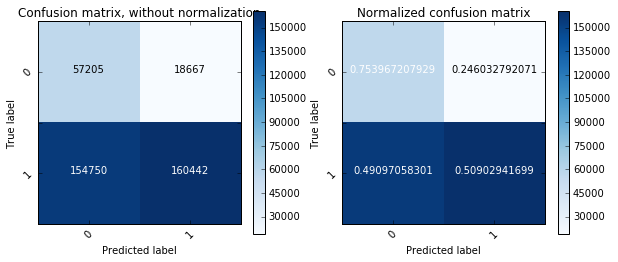

In [64]:
#use scikit-learn decision tree and set class_weight to handle the imbalance
tree = DecisionTreeClassifier(class_weight='balanced', max_depth=1)
tree.fit(X, y)
y_pred = tree.predict(X)
#here we use scikit-learn's predict_proba for the input to ROC_AUC_SCORE
y_prob = tree.predict_proba(X)
evaluate(y, y_pred, y_prob[:,1])

cpt_cnf(tree, X, y)

With the "balanced" option, scikit-learn decision tree has set a threshold so that the prediction accuracies of the two classes to be more comparable.

In [65]:
graph = print_tree(tree, ['grade'])
Image(graph.create_png())

NameError: global name 'pydotplus' is not defined

<img src = img1.png />

The split chosen (1.5) corresponds to a boundary between grades B and C.

### Model 3: Logistic Regression on Interest Rates

In [66]:
X = fulldf.int_rate

In [67]:
#Oversampling
#remove flutype)
X = np.reshape(X, (X.shape[0], 1))
y = np.reshape(y, (y.shape[0], 1))

print X.shape
print y.shape


X = np.concatenate((X, y), axis=1)
print X.shape

unq, unq_idx = np.unique(X[:, -1], return_inverse=True)
unq_cnt = np.bincount(unq_idx)
cnt = np.max(unq_cnt)
out = np.empty((cnt*len(unq) - len(X),) + X.shape[1:], X.dtype)
slices = np.concatenate(([0], np.cumsum(cnt - unq_cnt)))
for j in xrange(len(unq)):
    indices = np.random.choice(np.where(unq_idx==j)[0], cnt - unq_cnt[j])
    out[slices[j]:slices[j+1]] = X[indices]
out = np.vstack((X, out))


data_oversamp = out
print data_oversamp.shape

x_oversamp = data_oversamp[: , :-1]
y_oversamp = data_oversamp[: , -1]


x_train, x_test, y_train, y_test = train_test_split(x_oversamp, y_oversamp, test_size=0.2)
print x_train
#print x_train[:, -1].mean()
print y_train.mean()

#print sum(x_train_ovr[:, -1]-y_train_ovr)

(391064, 1)
(391064, 1)
(391064, 2)
(630384, 2)
[[ 0.2]
 [ 0.2]
 [ 0.1]
 ..., 
 [ 0.1]
 [ 0.2]
 [ 0.1]]
0.501034092329


/home/ankit/anaconda2/lib/python2.7/site-packages/numpy/core/fromnumeric.py:224: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return reshape(newshape, order=order)


Overall Accuracy: 0.626942265441
F1 Score: 0.63727924732
F1 Score (0 as "positive" since we are looking for "Default" cases): 0.615998824336
Weighted average F1 Score: 0.626551012314
Micro average F1 Score: 0.626942265441
Macro average F1 Score: 0.626639035828
Class 0 Accuracy: 0.593533668974
Class 1 Accuracy: 0.660908232961
ROC AUC Score: 0.676690408428
[[37725 25835]
 [21199 41318]]


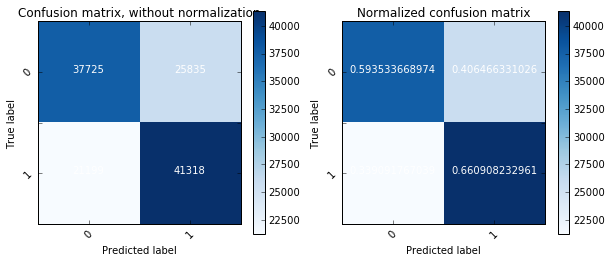

In [68]:
#Logistic Regresstion
LOG_ = LogisticRegression(C = 1000000) #C=1000000,penalty='l1'
model_LOG = LOG_.fit(x_train, y_train)
y_pred = LOG_.predict(x_test)
y_prob = LOG_.predict_proba(x_test)

evaluate(y_test, y_pred, y_prob[:, 1])
cpt_cnf(model_LOG, x_test, y_test)

**Cost-Based Models**

In [69]:
def cost(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    
    cost_true_positive = 90
    cost_true_negative = -10
    cost_false_positive = -15010
    cost_false_negative = -10
        
    n_true_positive = sum([(pred_val == 1) & (true_val == 1) for true_val, pred_val in zip(y_true, y_pred)])
    n_true_negative = sum([(pred_val == 0) & (true_val == 0) for true_val, pred_val in zip(y_true, y_pred)])
    n_false_positive = sum([(pred_val == 0) & (true_val == 1) for true_val, pred_val in zip(y_true, y_pred)])
    n_false_negative = sum([(pred_val == 1) & (true_val == 0) for true_val, pred_val in zip(y_true, y_pred)])
            
    total_cost = (np.array([[cost_true_negative, cost_false_negative], [cost_false_positive, cost_true_positive]]) *
                  np.array([[n_true_negative, n_false_negative], [n_false_positive, n_true_positive]])).sum()
    
    return total_cost

In [70]:
from sklearn.cross_validation import KFold

def cv_cost(model, n_folds, X, y):
    scores = pd.DataFrame({"class":["all"] + list(np.unique(y)), "total":0, "correct":0, "score":0, "cost":0})
    scores.set_index("class", inplace=True)
    kf = KFold(len(X), n_folds=n_folds, shuffle=True, random_state=0)
    for train_index, test_index in kf:
        train_X, test_X = X[train_index, :], X[test_index, :]
        train_y, test_y = y.ravel()[train_index], y.ravel()[test_index]  
        
        model.fit(train_X, train_y)
        
        for cls in np.unique(y):
            pred_y = model.predict(test_X[test_y==cls])

            n_correct = sum(pred_y == cls)
            n_total = sum(test_y==cls)
        
            cost_amt = cost(pred_y, [cls] * len(pred_y))
            scores.loc[cls, "correct"] += n_correct
            scores.loc[cls, "total"] += n_total
            scores.loc[cls, "cost"] += cost_amt
            scores.loc["all", "correct"] += n_correct
            scores.loc["all", "total"] += n_total
            scores.loc["all", "cost"] += cost_amt

    scores.score = scores.correct / scores.total
    return scores

In [71]:
# Baseline models
# All positive (label every loan as safe)
class Pos_model(object):
    def fit(self, X, y):
        return
    
    def predict(self, x):
        return np.array([1] * len(x))
    
    def score(self, x, y):
        y_pred = self.predict(x)
        y_err = y - y_pred
        return len(y_err[y_err == 0]) * 1. / len(y_err)

pos_model = Pos_model()
cv_cost(pos_model, 5, X, y)

,correct,cost,score,total
class,,,,
all,315192,-1110471440,0.805986,391064
0,0,-1138838720,0.000000,75872
1,315192,28367280,1.000000,315192


In [72]:
# All negative (label every loan as risky)
class Neg_model(object):
    def fit(self, X, y):
        return
    
    def predict(self, x):
        return np.array([0] * len(x))
    
    def score(self, x, y):
        y_pred = self.predict(x)
        y_err = y - y_pred
        return len(y_err[y_err == 0]) * 1. / len(y_err)

neg_model = Neg_model()
cv_cost(neg_model, 5, X, y)

,correct,cost,score,total
class,,,,
all,75872,-3910640,0.194014,391064
0,75872,-758720,1.000000,75872
1,0,-3151920,0.000000,315192


In [73]:
# Random (randomly predict safe or risky)
class Random_model(object):
    def fit(self, X, y):
        return
    
    def predict(self, x):
        return np.random.randint(0, 2, len(x))
    
    def score(self, x, y):
        y_pred = self.predict(x)
        y_err = y - y_pred
        return len(y_err[y_err == 0]) * 1. / len(y_err)

random_model = Random_model()
cv_cost(random_model, 5, X, y)

,correct,cost,score,total
class,,,,
all,195865,-553939340,0.500852,391064
0,38152,-566558720,0.502847,75872
1,157713,12619380,0.500371,315192
